## Решение тестового задания ML

### Поставленная задача

Требовалось создать и обучить сверточную нейронную сеть, которая локализует и классифицирует только 1 объект на изображении.

### Краткое описание решения

Модели обучались и валидировались на файлах из папки train,
тестировались на данных из папки valid.

Вначале был проведен небольшой анализ данных. Поскольку котов примерно в 2 раза меньше, чем собак, была продублирована часть файлов с котами в обучающей выборке, чтобы котов и собак стало поровну.

Для того, чтобы обучать по батчам, изображения были уменьшены с сохранением пропорций до размера 256 * 256.
К обучающей выборке применялись аугментации поворотов на 90 градусов, вертикальных и горизонтальных отражений.
Координаты bounding boxов были переведены в координаты относительно центра: x_min, y_min, x_max, y_max -> x_center, y_center, width, height

Использовался transfer learning. За основу была взята предобученная сеть resnet18, выход которой регрессировался к 5 координатам (1ая - предсказание класса, 2ая - 5ая - предсказание bounding box). Лучше всего оказались результаты, когда все ее слои были разморожены и обучались.

Также была попытка реализации и обучения unet, но она не помещалась в видеокарточку моего ноутбука, обучалась на collabe, который иногда отваливался, процесс обучения шел медленно.

В качестве loss функции использовалась взвешенная сумма binary_cross_entropy и mse/ciou_loss.

Для реализации моделей и обучения использовался pytorch.

### Полученные результаты

- **resnet18 с loss функцией 0.01 * mse + binary_cross_entropy**  
mIoU 81.56%, classification accuracy 97.5%, 14.84 ms, 3318 train, 830 valid, 400 test.
- **resnet18 с loss функцией 10 * ciou_loss + binary_cross_entropy**  
mIoU 83.97%, classification accuracy 97.5%, 14.4 ms, 3318 train, 830 valid, 400 test.
- **resnet18 с loss функцией 100 * ciou_loss + binary_cross_entropy**  
mIoU 84.57%, classification accuracy 93%, 15.65 ms, 3318 train, 830 valid, 400 test.
- **unet с loss функцией 10 * ciou_loss + binary_cross_entropy**  
mIoU 72.89%, classification accuracy 92%, 13.96 ms, 3318 train, 830 valid, 400 test.

Для поставленной задачи, когда ровно 1 объект на изображении, который либо кот, либо собака, можно было обучить 2 отдельных сети: одну для классификации, другую для локализации.
Предобученная resnet18 с 2мя последними размороженными слоями давала classification accuracy 99%.

### Если б было больше времени, решение могла улучшить

- Использовать больше аугментаций (повороты на углы, отличные от 90 градусов, сжатие и растяжение, изменение размера изображений, изменение цветовой гаммы).

- Более качественная настройка unet.

- Поэкспериментировать с другими архитектурами.

- Если бы результат принимался не в формате ipynb, разбить код на файлы.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import utils
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
import cv2
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
import time
import torchsummary
import random
import matplotlib.pyplot as plt
import os 
import io
from tqdm.notebook import tqdm
import torchvision.models as models
from torch import nn
from collections import OrderedDict
import math
import timeit

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

## Загрузка данных

In [3]:
DATASET_PATH = Path("cats_dogs_dataset/")
TRAIN_DATASET_PATH = DATASET_PATH / "train"
TEST_DATASET_PATH = DATASET_PATH / "valid"
RESULTS_ROOT = "tensorboard_results"

#### Файлы из папки train использовались для обучения и валидации

In [4]:
train_images_files = np.array(list(TRAIN_DATASET_PATH.glob('**/*.jpg')))
train_images_files.sort()

#### Файлы из папки valid использовались для тестирования

In [5]:
test_images_files = np.array(list(TEST_DATASET_PATH.glob('**/*.jpg')))
test_images_files.sort()

## Предобработка данных

### Распределение по формату данных

In [6]:
def get_distribution_image_mode(files):
    image_types = {}
    for file in files:
        image = Image.open(file)
        if image.mode not in image_types:
            image_types[image.mode] = 0
        image_types[image.mode] += 1    
    return image_types

print("Train: ", get_distribution_image_mode(train_images_files))
print("Test: ", get_distribution_image_mode(test_images_files))

Train:  {'RGB': 2984, 'L': 1}
Test:  {'RGB': 400}


В train присутствует одно не трехканальное изображение, сконвертируем его в трехканальное в классе датасета

### Соберем информацию о class id и roi в словарь, чтобы не тратить время на постоянное открытие и закрытие файлов

In [7]:
def get_info_dict(files):
    info = {}
    for file in files:
        image_info_file = file.parent / str(file.stem + '.txt')
        image_info_str = ''
        with open(image_info_file) as info_file:
            image_info_str = info_file.readline()
        info[file] = [int(x) for x in image_info_str.split()]
    return info

train_info = get_info_dict(train_images_files)
test_info = get_info_dict(test_images_files)

### Распределение по количеству котов и собак

In [8]:
CAT = 1
DOG = 2

In [9]:
def distribution_classes(info):
    image_classes = {CAT: 0, DOG: 0}
    for key, value in info.items():
        image_classes[value[0]] += 1
    return image_classes

print("Train", distribution_classes(train_info))
print("Test", distribution_classes(test_info))

Train {1: 911, 2: 2074}
Test {1: 126, 2: 274}


Котов примерно в 2 раза меньше, чем собак. Продублируем часть файлов с котами в train_images_files, чтобы котов и собак стало поровну

In [10]:
cats_files = [key for key, value in train_info.items() if value[0] == CAT]
train_images_files_equally = np.concatenate((train_images_files, np.random.choice(cats_files, len(train_images_files) - 2 * len(cats_files))))

### Распределение по породам

In [11]:
def distribution_plot(distribution_dict, title):
    plt.xticks(rotation='vertical')
    plt.title(title)
    plt.bar(*zip(*distribution_dict.items()))

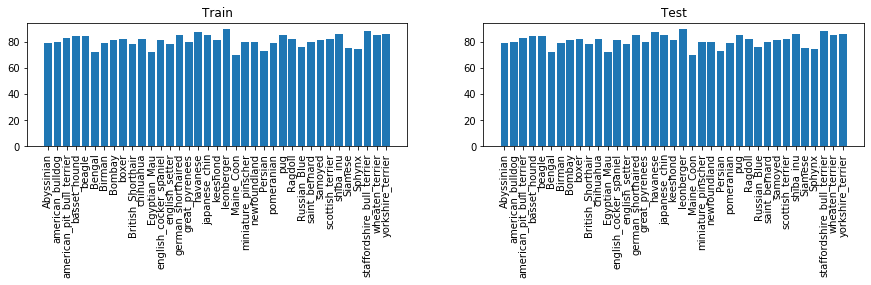

In [12]:
def distribution_breed(info):
    breed_types = {}
    for key, value in info.items():
        breed = key.stem.split('_')[:-1]
        breed = '_'.join(breed)
        if breed not in breed_types:
            breed_types[breed] = 0
        breed_types[breed] += 1
    return breed_types

plt.figure(figsize=(15, 5))
plt.subplot(221)
distribution_plot(distribution_breed(train_info), "Train")
plt.subplot(222)
distribution_plot(distribution_breed(train_info), "Test")
plt.show()

Распределение по породам практически равномерно

### Разделим train на обучающую и валидационную подвыборки

In [13]:
train_files, validation_files = train_test_split(train_images_files_equally, test_size=0.2, random_state=RANDOM_SEED)

## Датасет

### Функции для трансформации и аугментаций

In [14]:
COMMON_TRANSFORMS = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


COLOR_TRANSFORMS = transforms.Compose([
        transforms.ColorJitter(brightness=[0.6, 1.0], contrast=[0.3, 1.0], saturation=[0, 1], hue=0)
])


def get_proportional_resizing_params(image, image_size):
    ratio = min(image_size/image.size[0], image_size/image.size[1])
    imw = round(image.size[0] * ratio)
    imh = round(image.size[1] * ratio)
    padd_left = max(int((imh - imw)/2),0)
    padd_top = max(int((imw - imh)/2), 0)
    padd_right = max(int((imh - imw)/2) + (0 if abs(imw - imh) % 2 == 0 or imw >= imh else 1 ), 0)
    padd_bottom = max(int((imw - imh)/2) + (0 if abs(imw - imh) % 2 == 0 or imw <= imh else 1 ), 0)
    return ratio, [padd_left, padd_top, padd_right, padd_bottom]


def proportional_resizing_image(image, ratio, paddings):
    padd_left, padd_top, padd_right, padd_bottom = paddings
    imw = round(image.size[0] * ratio)
    imh = round(image.size[1] * ratio)
    img_transforms = transforms.Compose([
            transforms.Resize((imh, imw)),
            transforms.Pad((padd_left, padd_top, padd_right, padd_bottom), (128, 128, 128))
    ])
    return img_transforms(image)


def proportional_resizing(image, location, image_size):
    ratio, paddings = get_proportional_resizing_params(image, image_size)
    padd_left, padd_top, padd_right, padd_bottom = paddings
    resized_image = proportional_resizing_image(image, ratio, paddings)
    location = np.array(location) * ratio
    x_min, y_min, x_max, y_max = location
    x_min += padd_left
    x_max += padd_left
    y_min += padd_top
    y_max += padd_top
    return resized_image, [x_min, y_min, x_max, y_max]


def random_flip(image, location):
    random_horizontal_flip = random.random()
    random_vertical_flip = random.random()
    img_size = image.size[0]
    x_min, y_min, x_max, y_max = location
    if (random_horizontal_flip < 0.5):
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
        y_max, y_min = img_size - y_min, img_size - y_max
    if (random_vertical_flip < 0.5):
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        x_max, x_min = img_size - x_min, img_size - x_max
    return image, [x_min, y_min, x_max, y_max]


def random_rotate(image, location):
    x_min, y_min, x_max, y_max = location
    img_size = image.size[0]
    rotate = [Image.ROTATE_90, Image.ROTATE_180, Image.ROTATE_270, None]
    random_rotate = random.randint(0, 3)
    if rotate[random_rotate] != None:
        image = image.transpose(rotate[random_rotate])
        if random_rotate == 0:
            x_max, x_min, y_max, y_min = y_max, y_min, img_size - x_max, img_size - x_min
        elif random_rotate == 1:
            x_max, x_min, y_max, y_min = img_size - x_max, img_size - x_min, img_size - y_max, img_size - y_min
        elif random_rotate == 2:
            x_max, x_min, y_max, y_min = img_size - y_max, img_size - y_min, x_max, x_min
    if x_max < x_min:
        x_max, x_min = x_min, x_max
    if y_max < y_min:
        y_max, y_min = y_min, y_max
    return image, [x_min, y_min, x_max, y_max]

### Класс датасета

In [15]:
IMAGE_SIZE = 256
BATCH_SIZE = 20

def get_label(class_id):
    return 'cat' if class_id == 0 else 'dog'

class ImagesDataset(Dataset):

    def __init__(self, images_paths, images_info, to_transform=False, from_center=False):
        self._images_paths = images_paths
        self._images_info = images_info
        self._to_transform = to_transform
        self._from_center = from_center
        
    def __getitem__(self, i):
        
        image_file_path = self._images_paths[i]
        image = Image.open(image_file_path)
        image_info = self._images_info[image_file_path]
        
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        #if self._to_transform:
        #    image = COLOR_TRANSFORMS(image)
        
        image, location = proportional_resizing(image, image_info[1:], IMAGE_SIZE)
        
        if self._to_transform:
            image, location = random_flip(image, location)
            image, location = random_rotate(image, location)
                
        orig_image = transforms.ToTensor()(image)
        image = COMMON_TRANSFORMS(image)

        x_min, y_min, x_max, y_max = location
        class_id = image_info[0] - 1
        
        if self._from_center:
            w, h = x_max - x_min, y_max - y_min
            box = torch.Tensor([x_min + w / 2, y_min + h / 2, w, h])
        else:
            box = torch.Tensor([x_min, y_min, x_max - x_min, y_max - y_min])
        
        sample = { 'image': image,
                   'orig_image': orig_image,
                   'class_id': class_id,
                   'label': get_label(class_id),
                   'box': box,
                   'path': str(image_file_path),
                   'index': i }

        return sample

    def __len__(self):
        return len(self._images_paths)

train_dataset = ImagesDataset(train_files, train_info, to_transform=True, from_center=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = ImagesDataset(validation_files, train_info, to_transform=False, from_center=True)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
def draw_box(image, box, color, from_center=False):
    if from_center is True:
        x_c, y_c, w, h = box
        x = x_c - int(w / 2)
        y = y_c - int(h / 2)
    else:
        x, y, w, h = box           
    pil_image = transforms.ToPILImage()(image)
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle([(x, y), (x+w, y+h)], outline=color, width=3)
    
    return transforms.ToTensor()(pil_image)

In [17]:
def imshow(inp, title=None, size=20):
    inp = inp.numpy().transpose((1, 2, 0))
    fig = plt.figure(figsize=(size, size))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    return fig

In [18]:
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches = 'tight')
    plt.close(figure)                    
    buf.seek(0)
    image = Image.open(buf)
    return image

<Figure size 1440x1440 with 0 Axes>

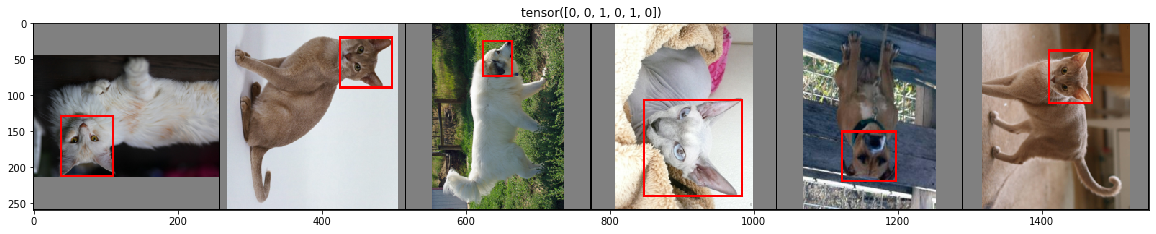

In [19]:
values = next(iter(train_loader))
inp = utils.make_grid([
    draw_box(img, box, "red", from_center=True) for img, box in zip(values['orig_image'][:6], values['box'][:6])
])
plt.figure(figsize=(20, 20))
imshow(inp, values['class_id'][:6]);

## Модель на основе предобученной resnet18

In [20]:
model_pretrained_bce = models.resnet18(pretrained=True)

for param in model_pretrained_bce.parameters():
    param.requires_grad = True
        
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512, 100)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(100, 5))
]))

model_pretrained_bce.fc = fc

## Модель на основе unet

In [21]:
class UNet(nn.Module):
    def __init__(self, channels=8):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(channels, 2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*channels),
            nn.ReLU(),
            nn.Conv2d(2*channels, 2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*channels),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(2*channels, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*channels, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(2*2*channels, 2*2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*2*channels, 2*2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*2*channels),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(2*2*2*channels, 2*2*2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*2*2*channels, 2*2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*2*channels),
            nn.ReLU(),
        )

        # decoder (upsampling)
        # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(2*2*2*2*channels, 2*2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*2*channels, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
        )
        # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(2*2*2*channels, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*channels, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
        )
        # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(48, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*channels, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
        )
        # 128 -> 256
        self.dec_conv3 = nn.Sequential(              # 256 -> 16
            nn.Conv2d(40, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*channels, 2*2*channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*channels, 2*2*channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*channels, 2*2*channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*channels, 2*2*channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU(),
            nn.Conv2d(2*2*channels, 2*2*channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2*2*channels),
            nn.ReLU()

        )
        self.fc = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x = self.pool0(e0)
        e1 = self.enc_conv1(x)
        x = self.pool0(e1)
        e2 = self.enc_conv2(x)
        x = self.pool0(e2)
        e3 = self.enc_conv3(x)
        x = self.pool0(e3)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder
        d0 = self.dec_conv0(torch.cat(
            (nn.functional.interpolate(b, size=e3.shape[2:4], mode='nearest'), e3),
            dim=1,
        ))
        d1 = self.dec_conv1(torch.cat(
            (nn.functional.interpolate(d0, size=e2.shape[2:4], mode='nearest'), e2),
            dim=1,
        ))
        d2 = self.dec_conv2(torch.cat(
            (nn.functional.interpolate(d1, size=e1.shape[2:4], mode='nearest'), e1),
            dim=1,
        ))
        d3 = self.dec_conv3(torch.cat(
            (nn.functional.interpolate(d2, size=e0.shape[2:4], mode='nearest'), e0),
            dim=1,
        ))
        d3 = d3.view(-1, 8192)
        res = self.fc(d3)
        return res
    
model_unet = UNet()

## Обучение

In [22]:
# source: https://github.com/ultralytics/yolov3/blob/eca5b9c1d36e4f73bf2f94e141d864f1c2739e23/utils/utils.py
def bbox_iou(box1, box2, from_center=False, GIoU=False, DIoU=False, CIoU=False):
    
    box1 = box1.t()
    box2 = box2.t()
    
    # transform from xywh to xyxy
    if from_center:
        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2
    else:
        b1_x1, b1_x2 = box1[0], box1[0] + box1[2]
        b1_y1, b1_y2 = box1[1], box1[1] + box1[3]
        b2_x1, b2_x2 = box2[0], box2[0] + box2[2]
        b2_y1, b2_y2 = box2[1], box2[1] + box2[3]

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
    union = (w1 * h1 + 1e-16) + w2 * h2 - inter

    iou = inter / union  # iou
    if GIoU or DIoU or CIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if GIoU:  # Generalized IoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + 1e-16  # convex area
            return iou - (c_area - union) / c_area  # GIoU
        if DIoU or CIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            # convex diagonal squared
            c2 = cw ** 2 + ch ** 2 + 1e-16
            # centerpoint distance squared
            rho2 = ((b2_x1 + b2_x2) - (b1_x1 + b1_x2)) ** 2 / 4 + ((b2_y1 + b2_y2) - (b1_y1 + b1_y2)) ** 2 / 4
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
                with torch.no_grad():
                    alpha = v / (1 - iou + v)
                return iou - (rho2 / c2 + v * alpha)  # CIoU

    return iou

In [23]:
def iou_10_bce_loss(predictions, targets, box):
    bce_loss = nn.BCELoss()(torch.sigmoid(predictions[:, 0]), targets.float())
    iou_loss = 10 * torch.sum(1.0 - bbox_iou(predictions[:, 1:], box, CIoU=True, from_center=True))/len(targets)
    loss = bce_loss + iou_loss
    return loss, bce_loss, iou_loss

In [24]:
def iou_100_bce_loss(predictions, targets, box):
    bce_loss = nn.BCELoss()(torch.sigmoid(predictions[:, 0]), targets.float())
    iou_loss = 100 * torch.sum(1.0 - bbox_iou(predictions[:, 1:], box, CIoU=True, from_center=True))/len(targets)
    loss = bce_loss + iou_loss
    return loss, bce_loss, iou_loss

In [25]:
def mse_0_01_bce_loss(predictions, targets, box):
    bce_loss = nn.BCELoss()(torch.sigmoid(predictions[:, 0]), targets.float())
    mse_loss = 0.01 * nn.MSELoss()(predictions[:, 1:], box)
    loss = bce_loss + mse_loss
    return loss, bce_loss, mse_loss

In [26]:
def train(net, loss_function, train_dataloader, optimizer, writer, device, epoch_id):
    tensorboard_records = {"train_loss_plot": [], 
                           "train_binary_cross_entropy_loss_plot": [],
                           "train_location_loss_plot": []}
    for items in tqdm(train_dataloader):
        images = items['image'].to(device)
        targets = items['class_id'].to(device)
        box = items['box'].to(device)
        net = net.train()
        predictions = net(images)
        loss, cross_entropy_loss, mse_loss = loss_function(predictions, targets, box)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        for key, value in zip(tensorboard_records.keys(), [loss, cross_entropy_loss, mse_loss]):
            tensorboard_records[key].append(value.cpu().detach().item())
    for key, value in tensorboard_records.items():
        writer.add_scalar(key, np.mean(value), global_step=epoch_id)
        print(key, np.mean(value))

In [27]:
def validate(net, loss_function, validation_dataloader, writer, tensorboard_tag, min_validation_loss, device, epoch_id):
    tensorboard_records = {"valid_loss_plot": [], 
                           "valid_binary_cross_entropy_loss_plot": [],
                           "valid_location_loss_plot": [],
                           "valid_accuracy_plot": [],
                           "valid_iou_plot": []}
    show_images = False
    image_count = 6
    for items in tqdm(validation_dataloader):
        net = net.eval()
        images = items['image'].to(device)
        targets = items['class_id'].to(device)
        boxes = items['box'].to(device)
        with torch.no_grad():
            predictions = net(images)
            loss, cross_entropy_loss, mse_loss = loss_function(predictions, targets, boxes)
            classes_pred = ((torch.sigmoid(predictions[:, 0]) > 0.5) == targets)
            boxes_pred = predictions[:, 1:]
            ious_batch = []
            for box_pred, box_target in zip(boxes_pred, boxes):
                iou = bbox_iou(box_pred.cpu().detach(), box_target.cpu().detach(), from_center=True)
                ious_batch.append(iou)
            for key, value in zip(tensorboard_records.keys(),\
                                  [loss, cross_entropy_loss, mse_loss, classes_pred, torch.Tensor(ious_batch)]):
                if key in ("valid_accuracy_plot", "valid_iou_plot"):
                    tensorboard_records[key].extend(value.cpu().detach())
                else:
                    tensorboard_records[key].append(value.cpu().detach().item())
            if show_images is False:
                show_images = True
                inp = utils.make_grid([
                    draw_box(img, box, "red", from_center=True) for img, box in zip(items['orig_image'][:image_count], boxes_pred[:image_count])
                ])
                imshow(inp, (torch.sigmoid(predictions[:, 0]) > 0.5).int()[:image_count])
                plt.show()
    validation_loss = np.mean(tensorboard_records["valid_loss_plot"])
    if (validation_loss < min_validation_loss):
        min_validation_loss = validation_loss
        torch.save(net.state_dict(), tensorboard_tag + ".best.pth")
        print("Model was saved")
    for key, value in tensorboard_records.items():
        writer.add_scalar(key, np.mean(value), global_step=epoch_id)
    print("valid_loss:", validation_loss)  
    print("valid_accuracy:", np.mean(tensorboard_records["valid_accuracy_plot"]))  
    print("mean iou:", np.mean(tensorboard_records["valid_iou_plot"]))
    return min_validation_loss

In [28]:
def train_cycle(model, loss_function, device, max_epoches, tensorboard_tag):
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-3)
    writer = SummaryWriter(Path(RESULTS_ROOT) / tensorboard_tag)
    min_validation_loss = 1000
    for epoch_id in range(max_epoches):
        print("Epoch:", epoch_id)
        train(model, loss_function, train_loader, optimizer, writer, device, epoch_id)
        min_validation_loss = validate(model, loss_function, validation_loader, writer, tensorboard_tag,\
                                       min_validation_loss, device, epoch_id)  

In [34]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
EPOCHES = 300

#### Обучение модели model_pretrained_bce

In [ ]:
train_cycle(model_pretrained_bce, iou_10_bce_loss, DEVICE, EPOCHES, "resnet18_10_iou_bce")

## Тестирование

In [30]:
def draw_confusion_matrix(test_loader, model, device):
    test_accuracy = []
    confusion_matrix = np.zeros([2, 2], int)
    confusion_matrix_detection = np.zeros([2, 2], int)
    with torch.no_grad():
        for items in tqdm(test_loader):
            model = model.eval()
            images = items['image'].to(DEVICE)
            targets = items['class_id'].to(DEVICE)
            box = items['box'].to(DEVICE)
            predictions = model(images)
            classPred = ((torch.sigmoid(predictions[:, 0]) > 0.5) == targets)
            boxPreds = predictions[:, 1:]
            test_accuracy.extend(classPred.cpu().detach())            
            for target, targetPred in zip(targets, (torch.sigmoid(predictions[:, 0]) > 0.5).cpu()):
                confusion_matrix[target, targetPred] += 1
            del images
            del predictions

    print("Accuracy: " + str(np.mean(test_accuracy)))
    print(confusion_matrix)
    plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
    plt.show()

In [31]:
test_dataset = ImagesDataset(test_images_files, test_info, to_transform=False, from_center=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=6,
    shuffle=True
)

In [32]:
def test_cycle(model, tensorboard_tag, device, batches_to_show):
    model = model.to(device)
    model.load_state_dict(torch.load(tensorboard_tag + ".best.pth"))
    model = model.eval()
    ious = []
    batch_num = 0
    with torch.no_grad():
        for items in tqdm(test_loader):
            ious_batch = []
            images = items['image'].to(DEVICE)
            targets = items['class_id'].to(DEVICE)
            boxes = items['box'].to(DEVICE)
            predictions = model(images)
            box_preds = predictions[:, 1:]
            for box_pred, box_target in zip(box_preds, boxes):
                iou = bbox_iou(box_pred.cpu().detach(), box_target.cpu().detach(), from_center=True)
                ious_batch.append(iou)
            ious.extend(ious_batch)
            if batch_num < batches_to_show:
                batch_num += 1
                inp = utils.make_grid([
                    draw_box(draw_box(img, box, "red", from_center=True), box_true, "green", from_center=True) for img, box, box_true \
                    in zip(items['orig_image'][:], box_preds[:], items['box'][:])
                ])
                plt.figure(figsize=(20, 20))
                imshow(inp, (torch.sigmoid(predictions[:, 0]) > 0.5).int()[:])
                plt.show()
                print(ious_batch)
            del images
            del predictions
    print("iou", np.mean(ious))
    draw_confusion_matrix(test_loader, model, device)

#### Результаты тестирования для модели resnet18 с loss функцией 10 * ciou + bce и демонстрация работы на картинках из первых 2ух батчей

<Figure size 1440x1440 with 0 Axes>

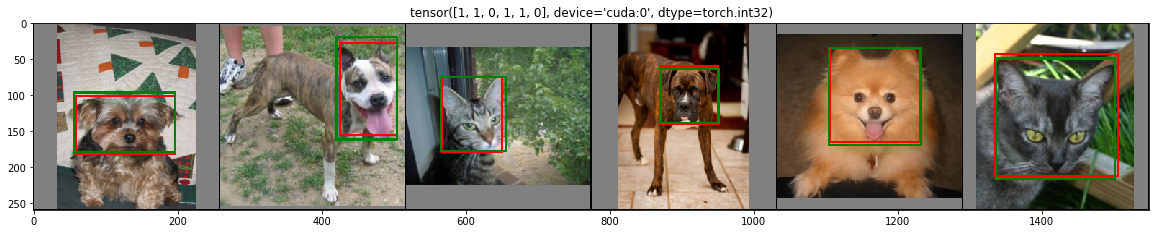

[tensor(0.9032), tensor(0.8421), tensor(0.9167), tensor(0.9187), tensor(0.9322), tensor(0.9154)]


<Figure size 1440x1440 with 0 Axes>

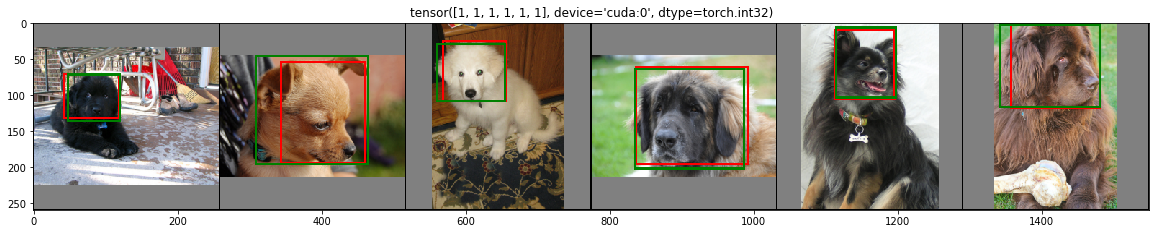

[tensor(0.8316), tensor(0.7037), tensor(0.8801), tensor(0.9158), tensor(0.9224), tensor(0.8612)]

iou 0.83969134



Accuracy: 0.975
[[118   8]
 [  2 272]]


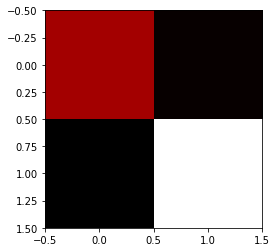

In [35]:
test_cycle(model_pretrained_bce, "resnet18_10_iou_bce", DEVICE, batches_to_show=2)

#### Результаты тестирования для модели unet с loss функцией 10 * ciou + bce и демонстрация работы на картинках из первых 2ух батчей

<Figure size 1440x1440 with 0 Axes>

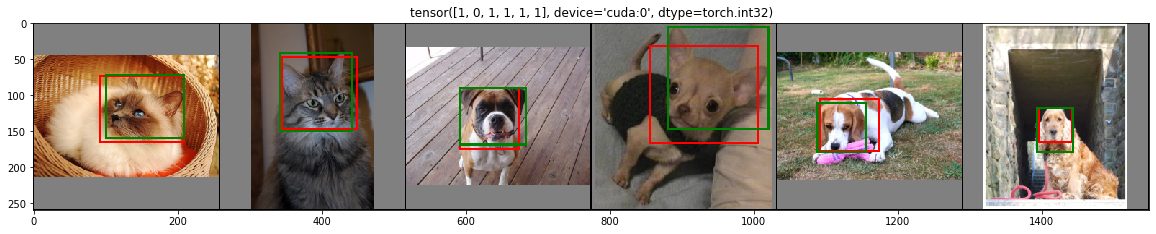

[tensor(0.8608), tensor(0.8361), tensor(0.8542), tensor(0.5775), tensor(0.6863), tensor(0.7367)]


<Figure size 1440x1440 with 0 Axes>

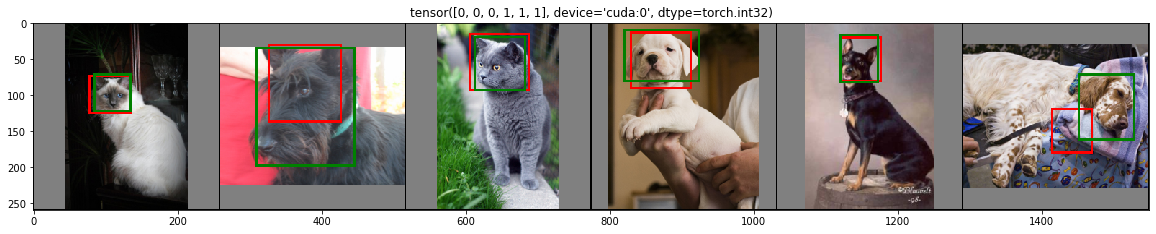

[tensor(0.8404), tensor(0.4560), tensor(0.8103), tensor(0.7058), tensor(0.8579), tensor(0.0849)]

iou 0.7288782



Accuracy: 0.92
[[104  22]
 [ 10 264]]


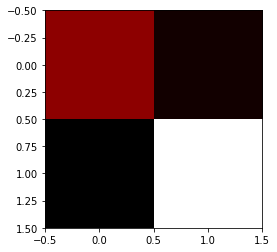

In [36]:
test_cycle(model_unet, "model_unet_more_iou_bce", DEVICE, batches_to_show=2)

### Время прохода по одному изображению на gpu

In [37]:
def proportional_unresizing_location(location, ratio, paddings):
    padd_left, padd_top, padd_right, padd_bottom = paddings
    xc, yc, w, h = location
    xc -= padd_left
    yc -= padd_top
    xc /= ratio
    yc /= ratio
    w /= ratio
    h /= ratio
    return [xc, yc, w, h]

In [38]:
def predict_by_image(model, image_file_path, show=True):
    
    # load image
    image = Image.open(image_file_path)
    orig_image = transforms.ToTensor()(image)
    
    # Prepare image
    ratio, paddings = get_proportional_resizing_params(image, IMAGE_SIZE)
    image = proportional_resizing_image(image, ratio, paddings)
    image = COMMON_TRANSFORMS(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
     # Get prediction
    with torch.no_grad():
        prediction = model(image)
        box_pred = prediction[0, 1:].cpu().detach().numpy()
        class_pred = (torch.sigmoid(prediction[0, 0]) > 0.5).int().cpu().detach().numpy()
        box = proportional_unresizing_location(box_pred, ratio, paddings)
        if show:
            image_with_box = draw_box(orig_image, box, "red", from_center=True)
            imshow(image_with_box, class_pred, size=5)
            plt.show()
    
    return get_label(class_pred), box

In [39]:
def get_time(model, tensorboard_tag, device, image_file):
    model = model.to(device)
    model.load_state_dict(torch.load(tensorboard_tag + ".best.pth"))
    model = model.eval()   
    
    class_pred, box = predict_by_image(model, image_file, show=True)
    
    time = (timeit.timeit('predict_by_image(model_pretrained_bce, image_file, show=False)', \
               'from __main__ import predict_by_image, model_pretrained_bce, image_file', number=100)/100) * 1000
    return time, class_pred, box

#### Время на выполнение одного прохода для модели resnet18 с loss функцией 10 * ciou + bce

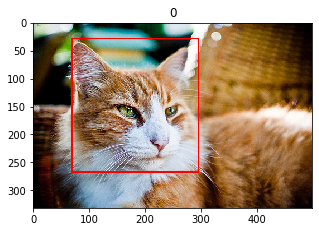

Time, ms: 14.39806400000009
Class label:  cat
Box:  [182.38502740859985, 147.79579639434814, 229.5549213886261, 239.71159756183624]


In [40]:
image_file = TEST_DATASET_PATH / "Maine_Coon_135.jpg"
time, class_pred, box = get_time(model_pretrained_bce, "resnet18_10_iou_bce", DEVICE, image_file)
print("Time, ms:", time)
print("Class label: ", class_pred)
print("Box: ", box)

#### Время на выполнение одного прохода для модели unet с loss функцией 10 * ciou + bce

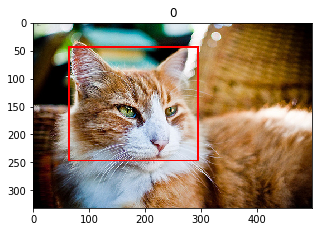

Time, ms: 13.959105000000136
Class label:  cat
Box:  [179.55398559570312, 145.27444541454315, 232.80256986618042, 205.40232956409454]


In [41]:
image_file = TEST_DATASET_PATH / "Maine_Coon_135.jpg"
time, class_pred, box = get_time(model_unet, "model_unet_more_iou_bce", DEVICE, image_file)
print("Time, ms:", time)
print("Class label: ", class_pred)
print("Box: ", box)